# Creating a Databunch for Basecalling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *

import jkbc.utils.preprocessing as prep
import jkbc.utils.postprocessing as pop
import jkbc.utils.files as f

## Constants

In [3]:
BLANK_ID = 4
C = 5
D_in = 300
D_h = 201
D_out_max = 60
BS = 64 # batch size
LR = 0.05

DEVICE = torch.device("cpu")
#DEVICE = torch.device("cuda:0")

## Load Data

In [4]:
#base_dir = "models" # Change this line if the data is located elsewhere
base_dir = "./feather-files/"
path_data = Path(base_dir)
data_set_name = 'Range0-100-FixLabelLen60'
feather_folder = path_data/data_set_name

In [5]:
# Read data from feather
data = f.read_data_from_feather_file(feather_folder)
x, y_train = data

# Convert to databunch
train, valid = prep.convert_to_databunch(data, split=.8, device=DEVICE, window_size=D_in)
databunch = DataBunch.create(train, valid, bs=BS)

In [6]:
# Create lengths to be used in ctc_loss
y_pred_lengths, y_lengths = prep.get_y_lengths(D_in, D_out_max, BS)

## Model

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, D_h)
        self.lin2 = nn.Linear(D_h, C)
    
    #   forward(self, x: Tensor[D_in, BS, 1]) -> Tensor[D_in, BS, C]
    def forward(self, xb):
        x1 = self.lin1(xb).clamp(min=0)
        return self.lin2(x1)  

In [8]:
ctc_loss = nn.CTCLoss()
def ctc_loss_custom(y_pred_b: torch.Tensor, y_b: torch.Tensor) -> float:
    if y_pred_lengths.shape[0] != y_pred_b.shape[0]:
        new_len = y_pred_b.shape[0]
        y_pred_lengths_ = y_pred_lengths[:new_len]
        y_lengths_ = y_lengths[:new_len]
    else:
        y_pred_lengths_ = y_pred_lengths
        y_lengths_ = y_lengths
    
    y_pred_b_ = y_pred_b.reshape((y_pred_b.shape[1], y_pred_b.shape[0], C))
    
    return ctc_loss(y_pred_b_, y_b, y_pred_lengths_, y_lengths_)    

In [9]:
loss_func = ctc_loss_custom

In [10]:
learner = Learner(databunch, SimpleModel(), loss_func=loss_func)

In [11]:
learner.fit(1)

epoch,train_loss,valid_loss,time
0,0.775687,0.796746,00:23


In [12]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-01
Min loss divided by 10: 6.31E-08


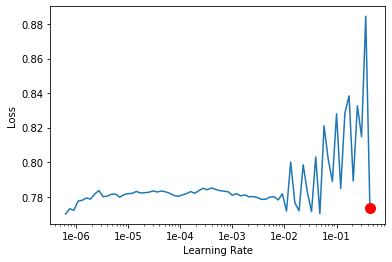

In [13]:
learner.recorder.plot(suggestion=True)

In [15]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.772283,0.760416,00:23
1,0.775575,0.801206,00:23


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/opt/anaconda/envs/mi/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/anaconda/envs/mi/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jonatan/.local/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 21, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda/envs/mi/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/jonatan/.local/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 284, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/anaconda/envs/mi/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/opt/anaconda/envs/mi/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return re

KeyboardInterrupt: 